In [5]:
import torch
from torchvision import models

import matplotlib.pyplot as plt
import numpy as np

from torchvision import transforms
from PIL import Image

torch.Size([3, 21, 520, 520])
Image 1, center pixel class: cow


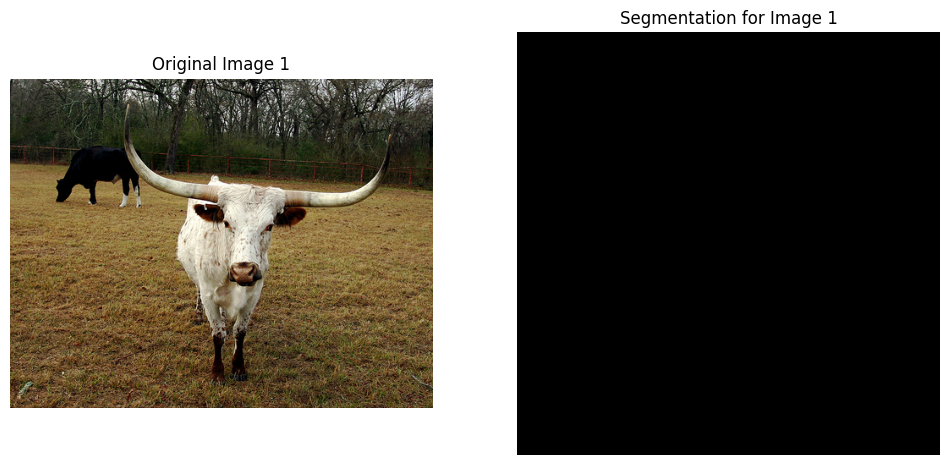

Image 2, center pixel class: cat


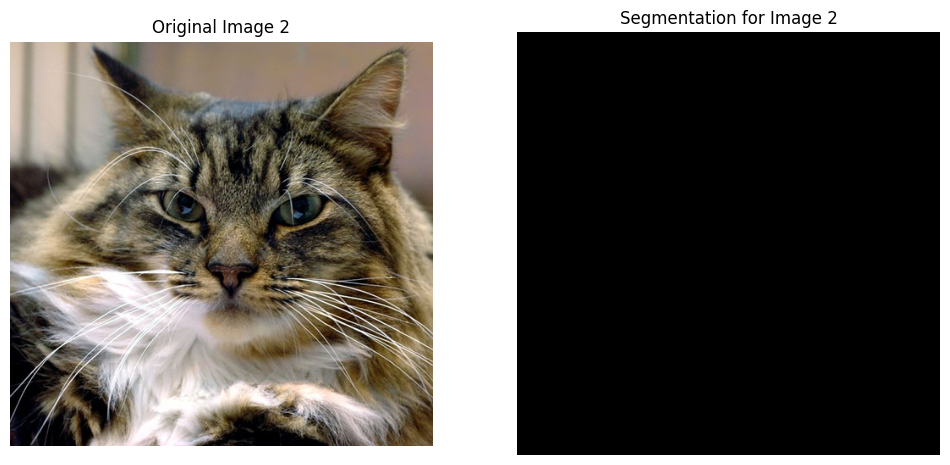

Image 3, center pixel class: background


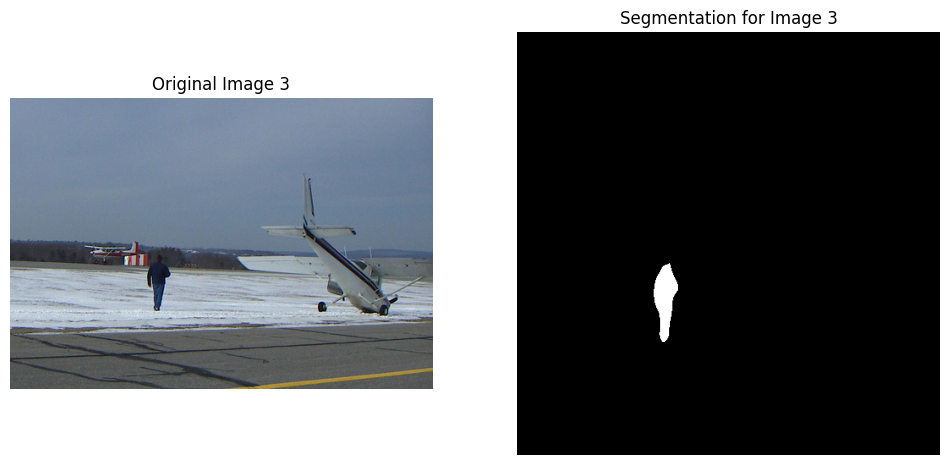

In [6]:
CLASS_FOR_MASK_GEN = 'person'
CLASS_INDEX = -1 
PASCAL_VOC_LABELS = {
    0: 'background',
    1: 'aeroplane',
    2: 'bicycle',
    3: 'bird',
    4: 'boat',
    5: 'bottle',
    6: 'bus',
    7: 'car',
    8: 'cat',
    9: 'chair',
    10: 'cow',
    11: 'diningtable',
    12: 'dog',
    13: 'horse',
    14: 'motorbike',
    15: 'person',
    16: 'pottedplant',
    17: 'sheep',
    18: 'sofa',
    19: 'train',
    20: 'tvmonitor',
}

for key, value in PASCAL_VOC_LABELS.items():
    if value == CLASS_FOR_MASK_GEN:
        CLASS_INDEX = key
        break

# Load a pre-trained DeepLabV3 model
model = models.segmentation.deeplabv3_resnet101(pretrained=True)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

preprocess = transforms.Compose([
    transforms.Resize((520, 520)),  # this step is required because the input images can have different sizes
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_images = []
input_tensors = []
for i in range(1, 4):
    input_image = Image.open(f"test{i}.jpg")
    input_images.append(input_image)
    processed_tensor = preprocess(input_image)
    input_tensors.append(processed_tensor)

input_batch = torch.stack(input_tensors).to(device)

with torch.no_grad():
    output = model(input_batch)['out']
print(output.shape)
output_predictions = output.argmax(1)  # Get predictions for each image in the batch

for i, op in enumerate(output_predictions):
    op_numpy = op.cpu().numpy()

    print(f"Image {i+1}, center pixel class:", PASCAL_VOC_LABELS.get(op_numpy[250,250], 'Unknown'))

    # Generate random colors for each class for visualization
    # num_classes = 21  # Including the background class
    # np.random.seed(42)
    # label_colors = np.random.randint(0, 255, size=(num_classes, 3))
    # segmentation = label_colors[op_numpy]

    num_classes = 21
    label_colors = np.zeros((num_classes, 3), dtype=int)
    label_colors[CLASS_INDEX] = [255, 255, 255]   # change to white
    segmentation = label_colors[op_numpy]

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(input_images[i])
    ax[0].set_title(f"Original Image {i+1}")
    ax[0].axis('off')
    ax[1].imshow(segmentation)
    ax[1].set_title(f"Segmentation for Image {i+1}")
    ax[1].axis('off')

    plt.show()
